In [1]:
import os

folder_path = "/Users/asritha/Downloads/artresortation/eclimate data/"


files = os.listdir(folder_path)
pm2_files = [f for f in files if f.endswith('.pm2')]

print(f"You have {len(pm2_files)} PM2 files. Here are all of them:\n")


gallery_files = []
obix_files = []
other_files = []

for file in sorted(pm2_files):
    if 'GALLERIES' in file.upper():
        gallery_files.append(file)
    elif 'OBIX' in file.upper():
        obix_files.append(file)
    else:
        other_files.append(file)

if gallery_files:
    print(f"GALLERIES files ({len(gallery_files)}):")
    for f in gallery_files:
        print(f"  {f}")
    print()

if obix_files:
    print(f"OBIX files ({len(obix_files)}):")
    for f in obix_files:
        print(f"  {f}")
    print()

if other_files:
    print(f"OTHER files ({len(other_files)}):")
    for f in other_files:
        print(f"  {f}")

print(f"\nSUMMARY:")
print(f"Gallery files: {len(gallery_files)}")
print(f"OBIX files: {len(obix_files)}")
print(f"Other files: {len(other_files)}")
print(f"Total: {len(pm2_files)}")

You have 464 PM2 files. Here are all of them:

GALLERIES files (14):
  GALLERIES FIRST FLOOR - CERAMICS-GLASS GALLERY.pm2
  GALLERIES FIRST FLOOR - FURNITURE (2006).pm2
  GALLERIES FIRST FLOOR - FURNITURE GALLERY.pm2
  GALLERIES FIRST FLOOR - LOUNGE.pm2
  GALLERIES FIRST FLOOR - METALS GALLERY.pm2
  GALLERIES FIRST FLOOR - TEXTILE AND PAINTINGS.pm2
  GALLERIES FIRST FLOOR.pm2
  GALLERIES SECOND FLOOR - DOMINY SHOP (2006-2008).pm2
  GALLERIES SECOND FLOOR - DOMINY SHOP_2011-ONWARD.pm2
  GALLERIES SECOND FLOOR - GRAVES GALLERY.pm2
  GALLERIES SECOND FLOOR - LOUNGE.pm2
  GALLERIES SECOND FLOOR - SWF GALLERIES.pm2
  GALLERIES SECOND FLOOR.pm2
  Galleries 1st Floor South.pm2

OBIX files (156):
  (OBIX) 7thFlrCecilHall.pm2
  (OBIX) 8thFloorChilds.pm2
  (OBIX) 8thFloorPottery.pm2
  (OBIX) 8th_Floor_Study_Collection_4.pm2
  (OBIX) 9thFl_Storage.pm2
  (OBIX) AC1ReturnAir.pm2
  (OBIX) AC1SupplyAir.pm2
  (OBIX) AC2ReturnAir.pm2
  (OBIX) AC2SupplyAir.pm2
  (OBIX) AC3ReturnAir.pm2
  (OBIX) AC3Suppl

In [2]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path("/Users/asritha/Downloads/artresortation/eclimate data/")  

GALLERY_FILES = [
    "GALLERIES FIRST FLOOR - METALS GALLERY.pm2",
    "GALLERIES SECOND FLOOR - GRAVES GALLERY.pm2",
    "GALLERIES FIRST FLOOR - FURNITURE GALLERY.pm2",
    "GALLERIES FIRST FLOOR - CERAMICS-GLASS GALLERY.pm2",
    "GALLERIES SECOND FLOOR.pm2",
    "GALLERIES FIRST FLOOR - FURNITURE (2006).pm2",
    "GALLERIES FIRST FLOOR - LOUNGE.pm2",
    "GALLERIES FIRST FLOOR - TEXTILE AND PAINTINGS.pm2",
    "GALLERIES SECOND FLOOR - LOUNGE.pm2",
    "GALLERIES SECOND FLOOR - DOMINY SHOP_2011-ONWARD.pm2",
    "GALLERIES SECOND FLOOR - DOMINY SHOP (2006-2008).pm2",
    "GALLERIES FIRST FLOOR.pm2",
    "Galleries 1st Floor South.pm2",
    "GALLERIES SECOND FLOOR - SWF GALLERIES.pm2",
]

def load_pm2_file(path: Path) -> pd.DataFrame | None:
    if not path.exists():
        print(f"[skip] File not found: {path.name}")
        return None

    with open(path, "r", errors="ignore") as f:
        lines = f.readlines()

    start_idx = None
    for i, line in enumerate(lines):
        if "YYYY-MM-DD HH:MM" in line:  
            start_idx = i + 1
            break
    if start_idx is None:
        print(f"[warn] No header marker found in: {path.name}")
        return None

    rows = []
    for line in lines[start_idx:]:
        parts = [p for p in line.strip().split("\t") if p]
        if len(parts) < 3:
            continue
        ts = pd.to_datetime(parts[0], errors="coerce")
        tF = pd.to_numeric(parts[1], errors="coerce")
        rh = pd.to_numeric(parts[2], errors="coerce")
        if pd.notna(ts) and pd.notna(tF) and pd.notna(rh):
            rows.append((ts, tF, rh))

    if not rows:
        print(f"[warn] No valid data rows in: {path.name}")
        return None

    return pd.DataFrame(rows, columns=["DateTime", "Temp_F", "RH_pct"])


# ---- Load all galleries
all_frames = []
for fname in GALLERY_FILES:
    path = DATA_DIR / fname
    print(f"[load] {fname}")
    df = load_pm2_file(path)
    if df is not None and not df.empty:
        df["Gallery"] = fname.removesuffix(".pm2")
        all_frames.append(df)
    else:
        print(f"[skip] No data in {fname}")

if not all_frames:
    raise SystemExit("No gallery data loaded. Check DATA_DIR or filenames.")

gallery_df = pd.concat(all_frames, ignore_index=True)
print(f"[ok] Combined shape: {gallery_df.shape}")
print(f"[ok] Time coverage: {gallery_df['DateTime'].min()}  →  {gallery_df['DateTime'].max()}")

# ---- Add season column
gallery_df["Season"] = gallery_df["DateTime"].dt.month.map(
    lambda m: "summer" if m in [5,6,7,8,9] else "winter"
)


def gallery_stats(g: pd.DataFrame) -> pd.Series:
    # Daily swing analysis
    daily = (
        g.set_index("DateTime")
         .resample("1D")
         .agg({"RH_pct": ["min", "max"]})
         .dropna()
    )
    daily.columns = ["RH_min_d", "RH_max_d"]
    daily["RH_range"] = daily["RH_max_d"] - daily["RH_min_d"]
    daily["Season"] = daily.index.month.map(lambda m: "summer" if m in [5,6,7,8,9] else "winter")

    # swing-day counts
    days_total  = int((daily["RH_range"] > 10).sum())
    days_summer = int(((daily["RH_range"] > 10) & (daily["Season"]=="summer")).sum())
    days_winter = int(((daily["RH_range"] > 10) & (daily["Season"]=="winter")).sum())

    # seasonal slices
    summer = g[g["Season"] == "summer"]
    winter = g[g["Season"] == "winter"]

    summer_total = int(len(summer))
    winter_total = int(len(winter))

    # out-of-band masks
    summer_mask = (summer["RH_pct"] < 40) | (summer["RH_pct"] > 60)
    winter_mask = (winter["RH_pct"] < 30) | (winter["RH_pct"] > 55)

    # counts
    summer_out_count = int(summer_mask.sum())
    winter_out_count = int(winter_mask.sum())

    # percentages
    pct_summer_out = 100 * summer_out_count / summer_total if summer_total else 0.0
    pct_winter_out = 100 * winter_out_count / winter_total if winter_total else 0.0

    return pd.Series({
        "start": g["DateTime"].min(),
        "end":   g["DateTime"].max(),
        "n":     len(g),

        # temperature stats
        "Temp_min":  g["Temp_F"].min(),
        "Temp_max":  g["Temp_F"].max(),
        "Pct_T_outside_60_77": 100 * ((g["Temp_F"] < 60) | (g["Temp_F"] > 77)).mean(),
        "Temp_outside_60_77_count": int(((g["Temp_F"] < 60) | (g["Temp_F"] > 77)).sum()),

        # humidity stats
        "RH_min":  g["RH_pct"].min(),
        "RH_max":  g["RH_pct"].max(),
        "Pct_RH_outside_30_60": 100 * ((g["RH_pct"] < 30) | (g["RH_pct"] > 60)).mean(),

        # seasonal humidity out-of-band
        "RH_out_summer_40_60_count": summer_out_count,
        
        
        "RH_out_winter_30_55_count": winter_out_count,
        
        

        "Days_RH_range_gt10": days_total,
        "Days_RH_range_gt10_summer": days_summer,
        "Days_RH_range_gt10_winter": days_winter,
    })


# ---- Summary table
summary = (
    gallery_df
      .groupby("Gallery", as_index=False)
      .apply(gallery_stats)
      .reset_index(drop=True)
)

print("\n[summary] Climate stability by gallery:")
display(summary)
summary.to_csv("gallery_climate_summary.csv", index=False)



[load] GALLERIES FIRST FLOOR - METALS GALLERY.pm2
[load] GALLERIES SECOND FLOOR - GRAVES GALLERY.pm2
[load] GALLERIES FIRST FLOOR - FURNITURE GALLERY.pm2
[load] GALLERIES FIRST FLOOR - CERAMICS-GLASS GALLERY.pm2
[load] GALLERIES SECOND FLOOR.pm2
[load] GALLERIES FIRST FLOOR - FURNITURE (2006).pm2
[load] GALLERIES FIRST FLOOR - LOUNGE.pm2
[load] GALLERIES FIRST FLOOR - TEXTILE AND PAINTINGS.pm2
[load] GALLERIES SECOND FLOOR - LOUNGE.pm2
[load] GALLERIES SECOND FLOOR - DOMINY SHOP_2011-ONWARD.pm2
[load] GALLERIES SECOND FLOOR - DOMINY SHOP (2006-2008).pm2
[load] GALLERIES FIRST FLOOR.pm2
[load] Galleries 1st Floor South.pm2
[load] GALLERIES SECOND FLOOR - SWF GALLERIES.pm2
[ok] Combined shape: (971720, 4)
[ok] Time coverage: 2003-01-13 16:27:00  →  2025-08-15 13:00:00

[summary] Climate stability by gallery:


/var/folders/2l/14yhlpvn4pv4rlg7jw32j4hm0000gn/T/ipykernel_99417/990786874.py:153: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(gallery_stats)


,Gallery,start,end,n,Temp_min,Temp_max,Pct_T_outside_60_77,Temp_outside_60_77_count,RH_min,RH_max,Pct_RH_outside_30_60,RH_out_summer_40_60_count,RH_out_winter_30_55_count,Days_RH_range_gt10,Days_RH_range_gt10_summer,Days_RH_range_gt10_winter
0,GALLERIES FIRST FLOOR,2003-10-10 11:00:00,2004-10-29 06:59:00,2309,62.1,77.0,0.000000,0,34,61,0.043309,42,16,10,1,9
1,GALLERIES FIRST FLOOR - CERAMICS-GLASS GALLERY,2010-04-15 18:19:00,2011-05-09 14:28:00,3486,60.3,75.6,0.000000,0,22,59,0.172117,5,28,73,5,68
2,GALLERIES FIRST FLOOR - FURNITURE (2006),2006-02-27 19:39:00,2006-05-16 22:12:00,9362,62.1,73.0,0.000000,0,28,62,0.128178,832,3,44,9,35
3,GALLERIES FIRST FLOOR - FURNITURE GALLERY,2011-05-09 14:33:00,2014-07-11 09:53:00,181309,60.3,78.4,0.040814,74,24,72,1.346872,1792,6792,108,32,76
4,GALLERIES FIRST FLOOR - LOUNGE,2010-06-23 16:44:00,2014-02-11 13:08:00,204520,51.1,82.9,0.052318,107,23,84,3.418737,5697,14325,595,69,526
5,GALLERIES FIRST FLOOR - METALS GALLERY,2008-05-07 02:19:00,2010-04-15 14:19:00,4253,54.9,73.9,0.423231,18,30,62,0.023513,34,1,21,7,14
6,GALLERIES FIRST FLOOR - TEXTILE AND PAINTINGS,2011-06-13 15:00:00,2014-07-11 10:59:00,66504,61.5,77.3,0.009022,6,26,79,5.351558,1388,7228,101,18,83
7,GALLERIES SECOND FLOOR,2003-01-13 16:27:00,2003-12-31 16:20:00,202,66.9,75.9,0.000000,0,24,72,3.465347,9,12,0,0,0
8,GALLERIES SECOND FLOOR - DOMINY SHOP (2006-2008),2005-11-28 21:57:00,2008-05-06 12:22:00,5339,61.9,80.8,0.168571,9,23,66,3.727290,156,191,71,9,62
9,GALLERIES SECOND FLOOR - DOMINY SHOP_2011-ONWARD,2011-06-13 16:30:00,2014-07-11 11:30:00,66487,56.4,80.2,0.159430,106,29,72,9.113060,5093,3164,65,17,48


In [5]:
#all the galleries over time and humidity
import matplotlib.pyplot as plt
def plot_rh_all_galleries(gallery_df: pd.DataFrame, out_dir: Path | None = None, show: bool = False):
   
    if out_dir is not None:
        out_dir = Path(out_dir)
        out_dir.mkdir(parents=True, exist_ok=True)

    galleries = gallery_df["Gallery"].dropna().unique()
    for gallery_name in sorted(galleries):
        g = gallery_df[gallery_df["Gallery"] == gallery_name]
        if g.empty:
            print(f"[skip] No data for gallery: {gallery_name}")
            continue

        plt.figure(figsize=(12, 5))
        plt.plot(g["DateTime"], g["RH_pct"], linewidth=0.7)
        for y in (30, 40, 55, 60):
            plt.axhline(y)
        plt.title(f"RH% over time — {gallery_name}")
        plt.xlabel("Date")
        plt.ylabel("RH (%)")
        plt.tight_layout()

        if out_dir is not None:
            safe = (
                gallery_name.replace("/", "-")
                            .replace("\\", "-")
                            .replace(":", "-")
                            .replace("|", "-")
                            .replace("?", "")
                            .replace("*", "")
                            .strip()
            )
            fpath = out_dir / f"RH_over_time__{safe}.png"
            plt.savefig(fpath, dpi=150)
            print(f"[ok] Saved {fpath}")

        if show:
            plt.show()
        else:
            plt.close()


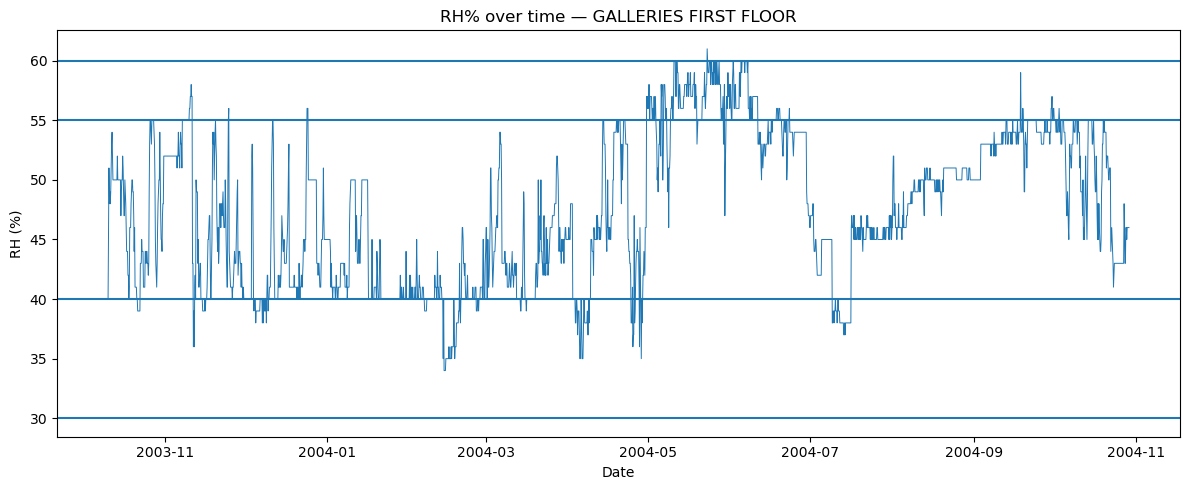

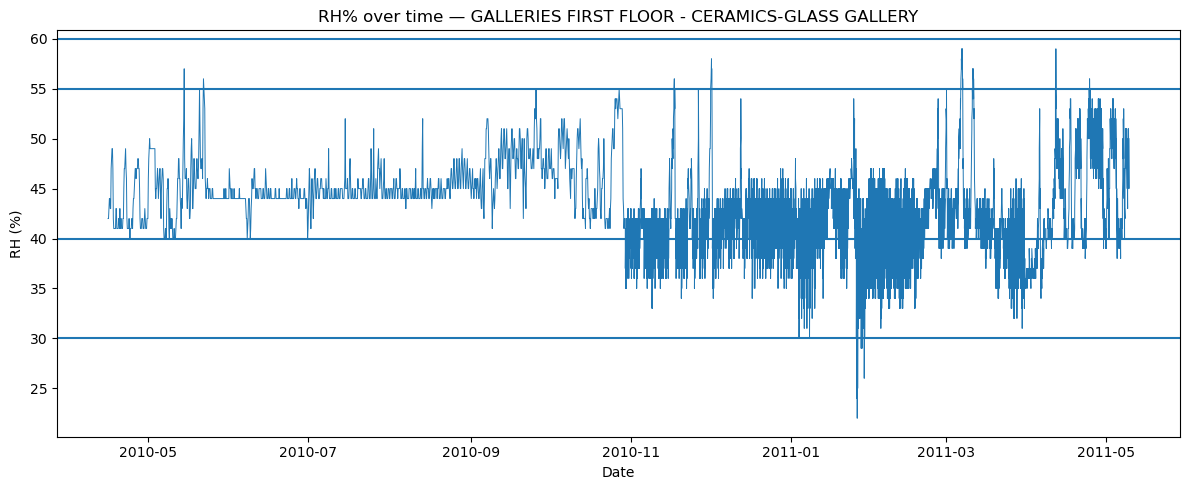

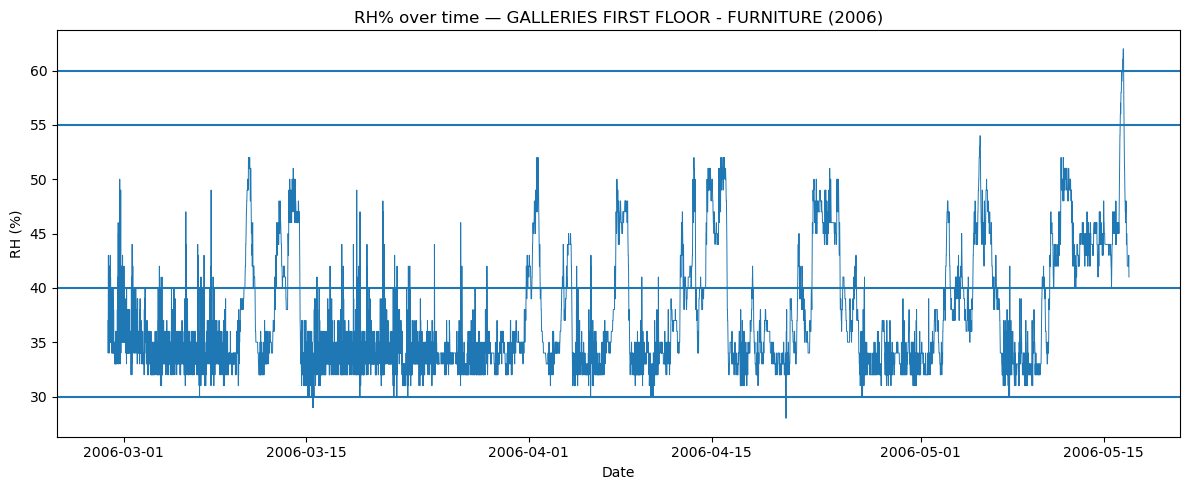

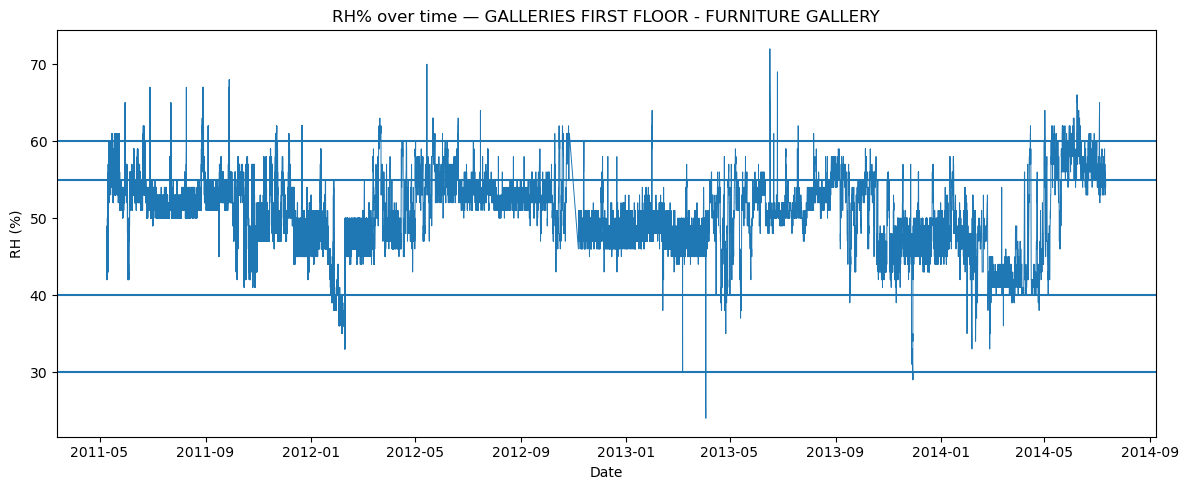

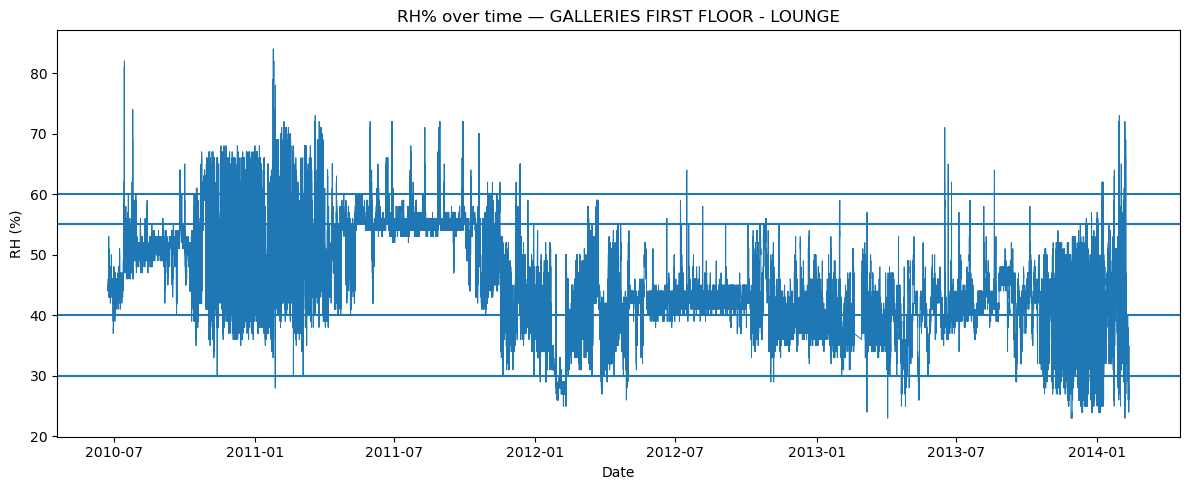

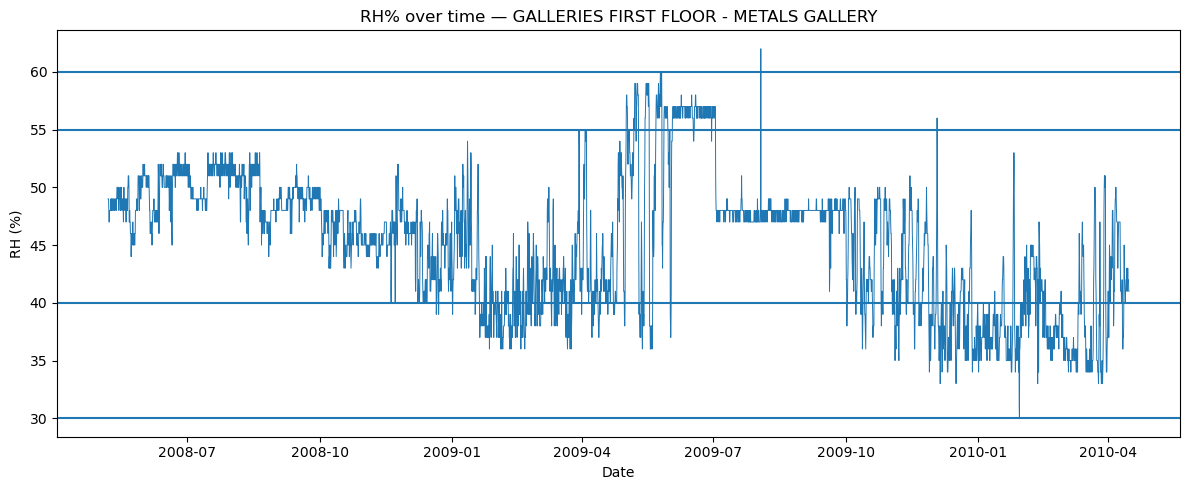

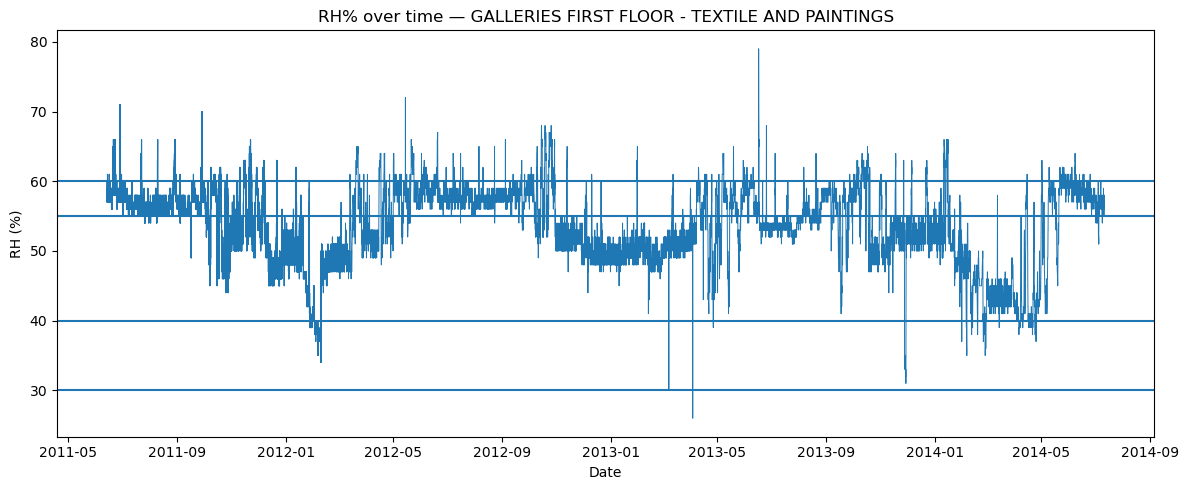

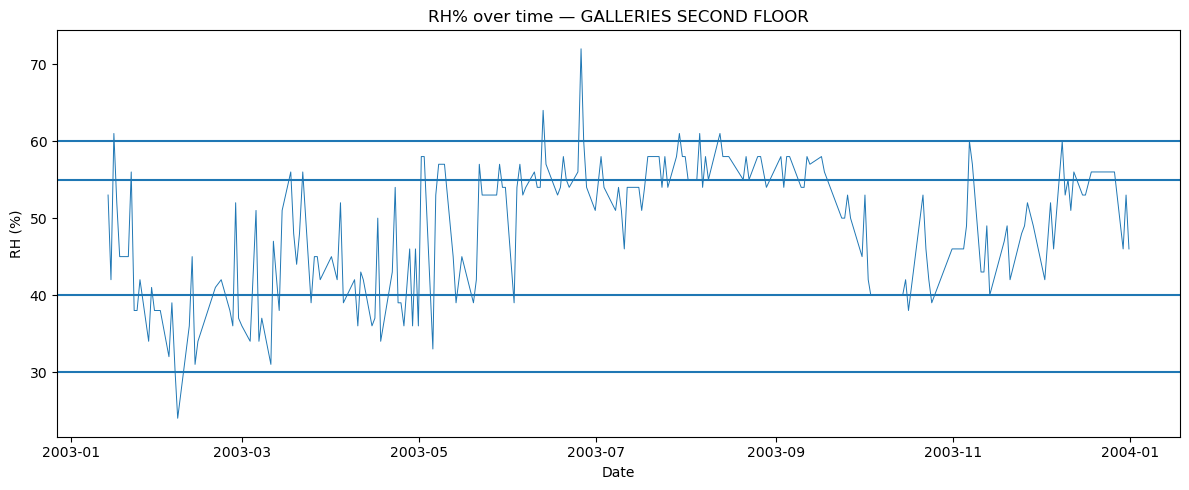

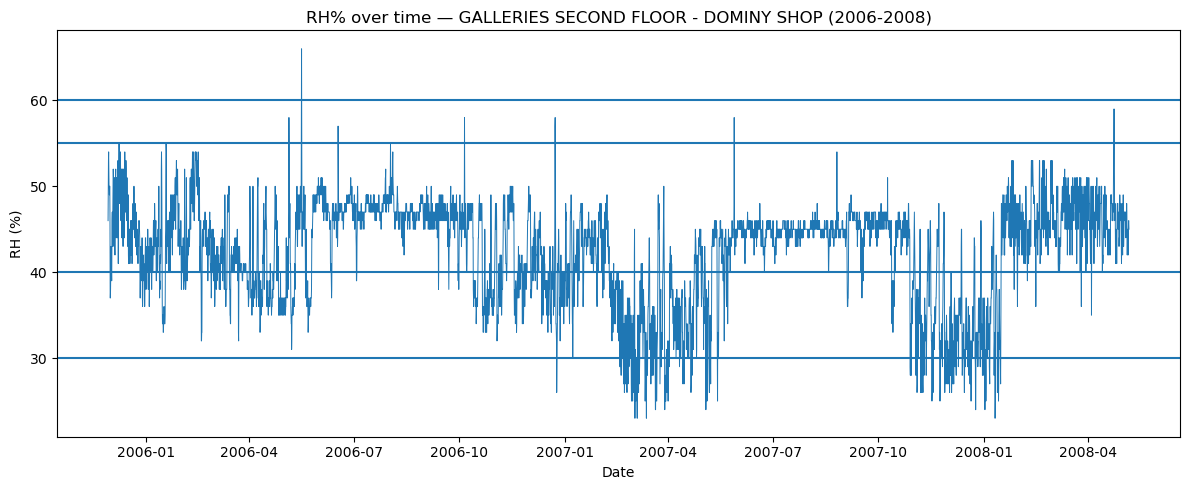

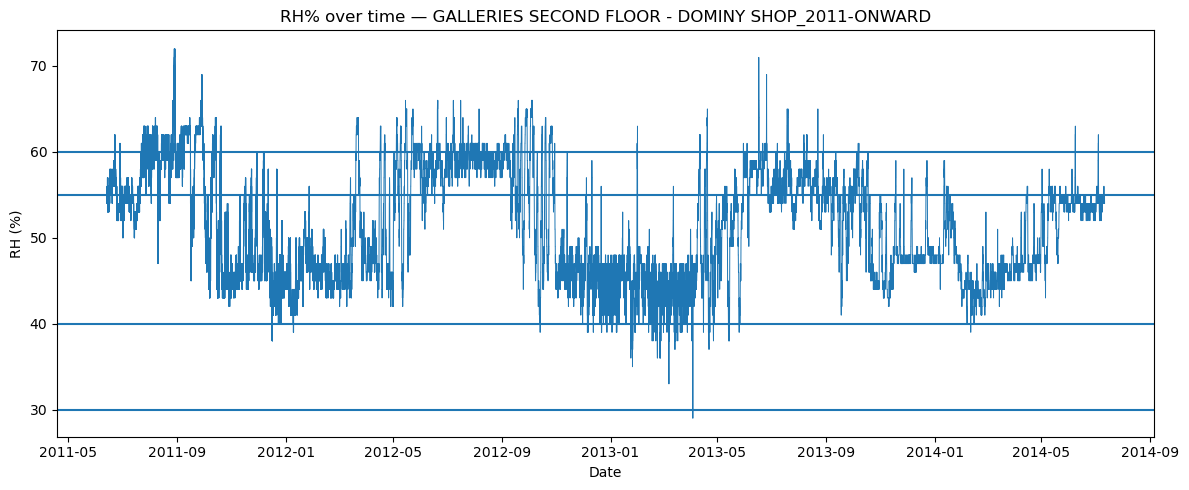

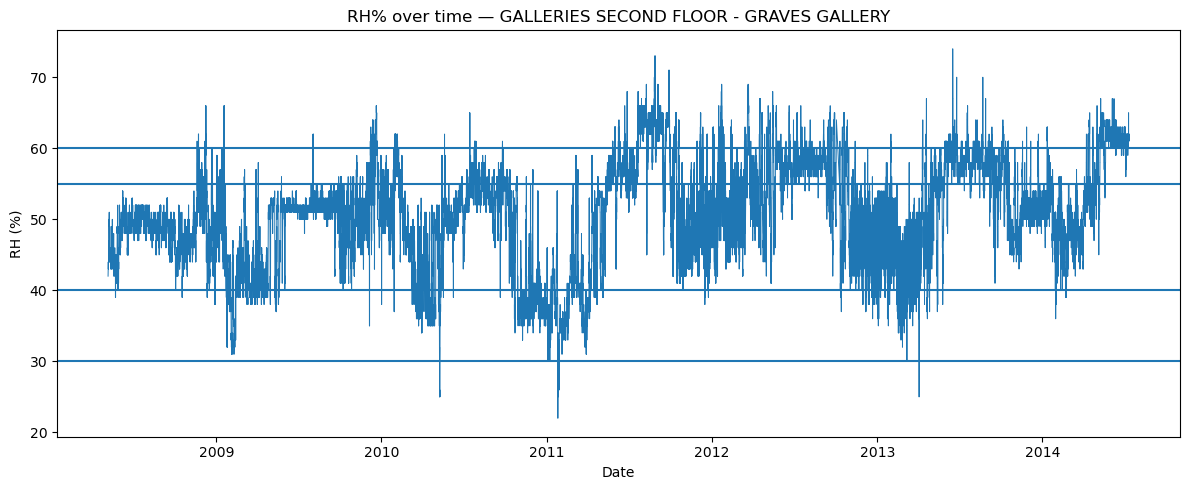

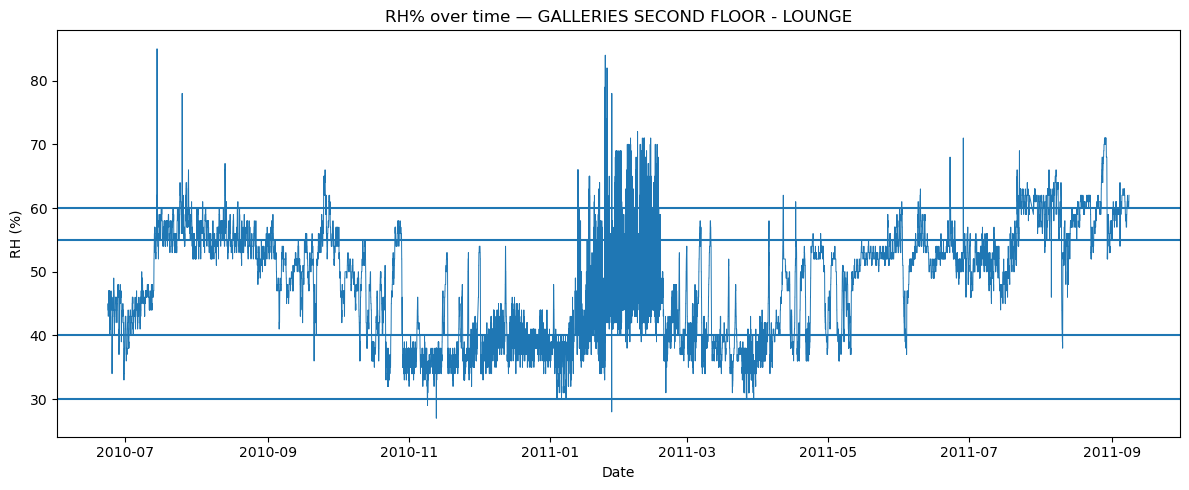

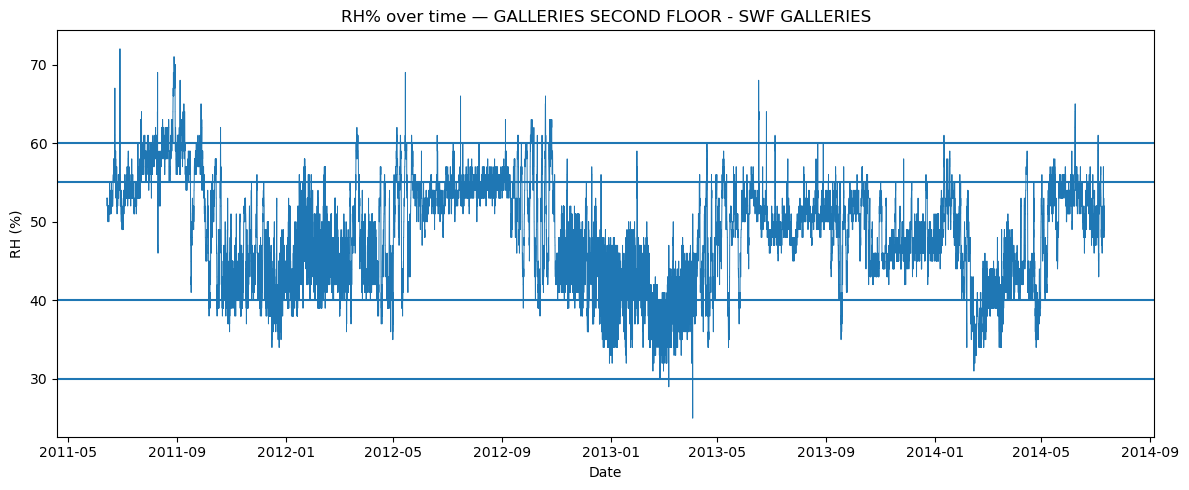

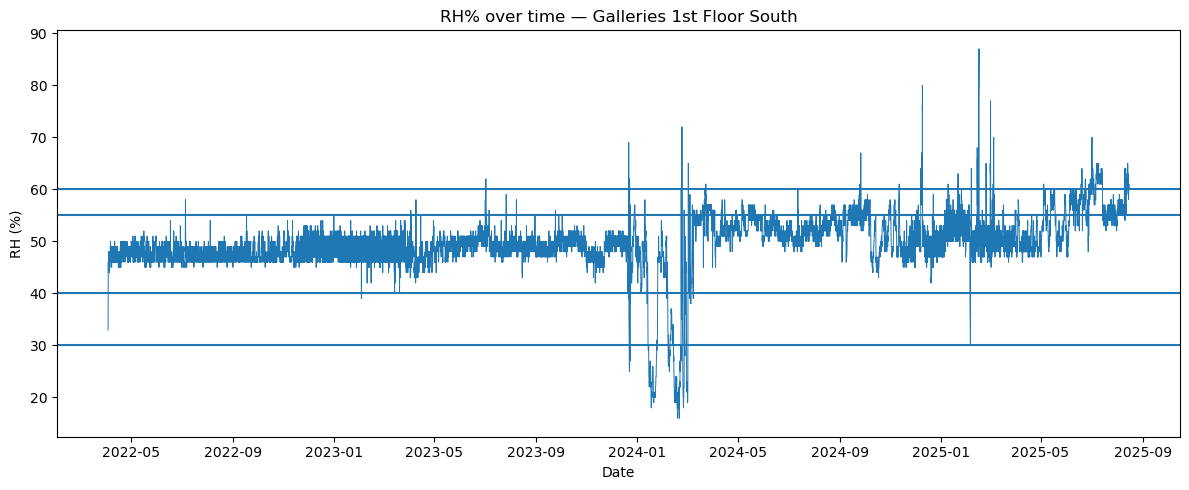

In [6]:
plot_rh_all_galleries(gallery_df, show=True)


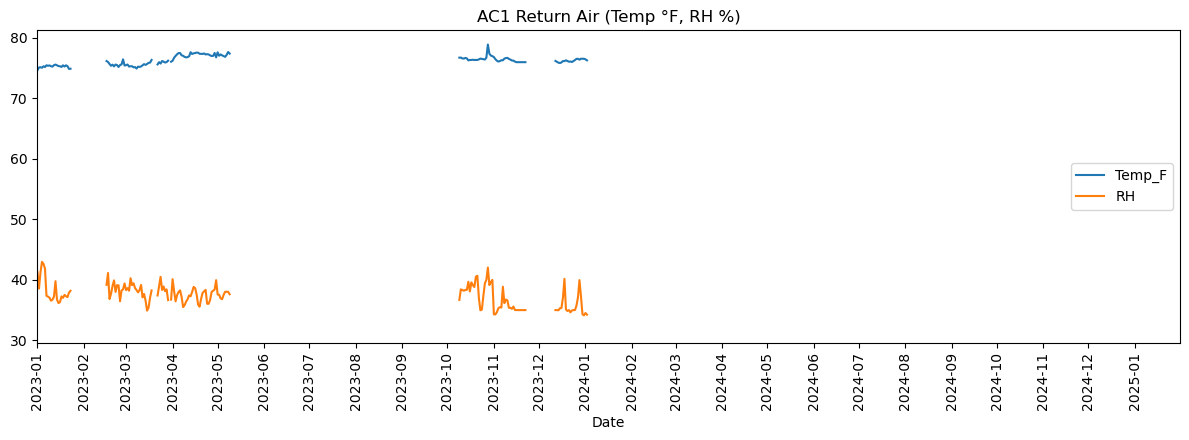

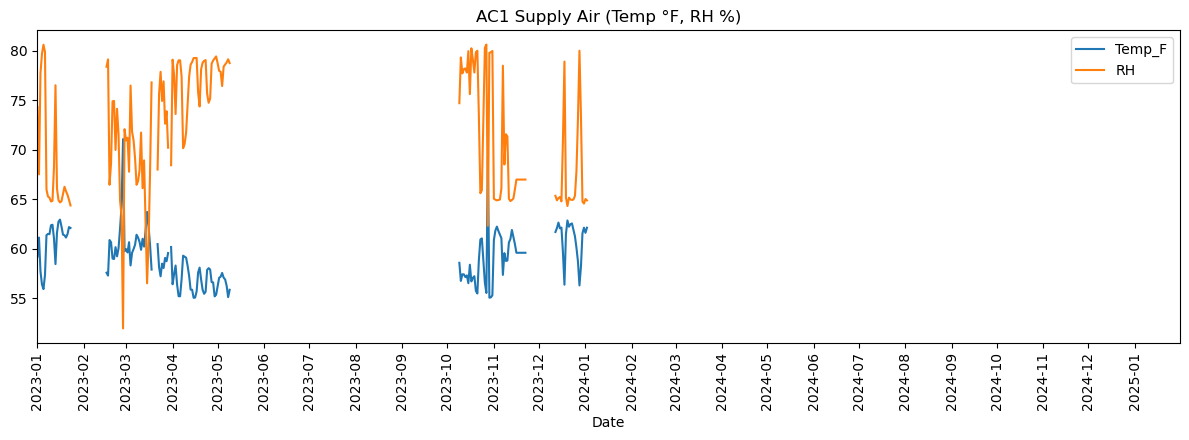

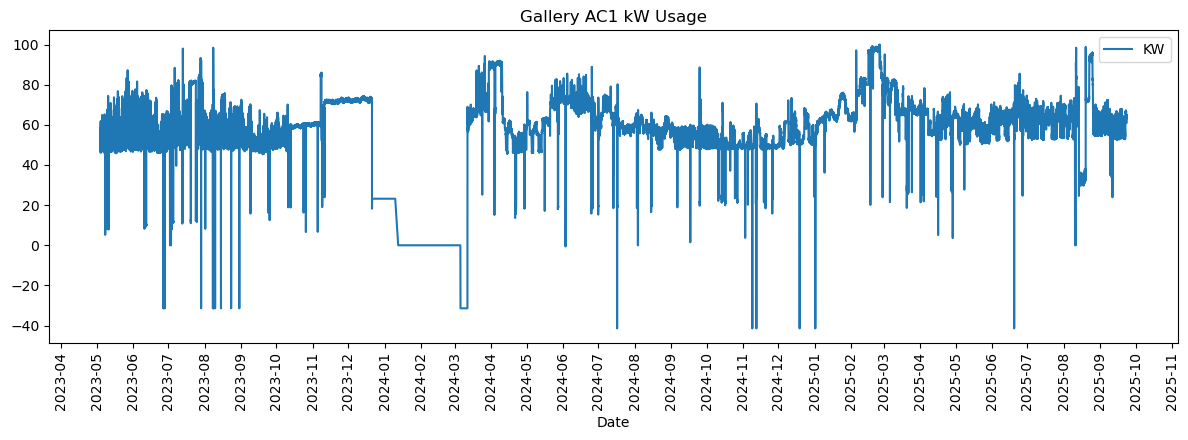

In [8]:
#ac1 return and supply air and energy from 2023 to 2024

%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def _read_text_lines(filepath, encoding="utf-8-sig"):
    try:
        with open(filepath, "r", encoding=encoding) as f:
            return f.readlines()
    except UnicodeDecodeError:
        with open(filepath, "r", encoding="latin-1") as f:
            return f.readlines()

def _strip_tz_suffix(ts: pd.Series) -> pd.Series:
    return ts.str.replace(r"\s[A-Z]{2,4}$", "", regex=True)

def load_pm2(filepath: str) -> pd.DataFrame:
    lines = _read_text_lines(filepath)
    header_idx = None
    for i, line in enumerate(lines):
        if line.startswith("YYYY-MM-DD"):
            header_idx = i
            break
    if header_idx is None:
        raise ValueError(f"Could not find 'YYYY-MM-DD' header in: {filepath}")

    df = pd.read_csv(
        filepath,
        sep="\t",
        skiprows=header_idx + 1,
        names=["DateTime", "Temp_F", "RH"],
        engine="python",
        encoding="latin-1"
    )
    df["DateTime"] = pd.to_datetime(df["DateTime"], errors="coerce")
    df["Temp_F"]   = pd.to_numeric(df["Temp_F"], errors="coerce")
    df["RH"]       = pd.to_numeric(df["RH"], errors="coerce")
    return df.dropna(subset=["DateTime"]).reset_index(drop=True)

def load_kw_csv(filepath: str) -> pd.DataFrame:
    lines = _read_text_lines(filepath, encoding="utf-8-sig")
    header_line = None
    for i, line in enumerate(lines):
        if line.strip().startswith("Timestamp,"):
            header_line = i
            break
    if header_line is None:
        raise ValueError("Could not locate 'Timestamp,...' header in KW CSV.")

    # Skip everything *before* the header row
    df = pd.read_csv(filepath, skiprows=header_line)

    ts_clean = _strip_tz_suffix(df["Timestamp"].astype(str).str.strip())
    df["DateTime"] = pd.to_datetime(ts_clean, format="%d-%b-%y %I:%M:%S %p", errors="coerce")
    df["KW"] = pd.to_numeric(df["Value"], errors="coerce")

    return df.dropna(subset=["DateTime"])[["DateTime", "KW"]]


def plot_series(df: pd.DataFrame, x: str, y_cols: list, title: str):
    plt.figure(figsize=(12, 4.5))
    ax = plt.gca()

    if ("Return" in title) or ("Supply" in title):
        # Show gaps: resample to daily and reindex 2023–2025
        start, end = "2023-01-01", "2025-01-31"
        daily = (df.set_index(x)[y_cols]
                   .resample("D").mean())
        idx = pd.date_range(start, end, freq="D")
        daily = daily.reindex(idx)       
        daily.index.name = x

        for col in y_cols:
            ax.plot(daily.index, daily[col], label=col)

        ax.set_xlim(pd.to_datetime(start), pd.to_datetime(end))
    else:
        # Energy: plot raw (auto limits)
        for col in y_cols:
            ax.plot(df[x], df[col], label=col)

    # Monthly ticks everywhere
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

    plt.title(title)
    plt.xlabel("Date")
    plt.legend()
    plt.tight_layout()
    plt.show()  


PM2_RETURN_PATH = "/Users/asritha/Downloads/artresortation/eclimate data/(OBIX) AC2ReturnAir.pm2"
PM2_SUPPLY_PATH = "/Users/asritha/Downloads/artresortation/eclimate data/(OBIX) AC2SupplyAir.pm2"
KW_CSV_PATH     = "/Users/asritha/Downloads/artresortation/tridium energy data/Gallery-AC2-KW.csv"

ret = load_pm2(PM2_RETURN_PATH).sort_values("DateTime")
sup = load_pm2(PM2_SUPPLY_PATH).sort_values("DateTime")
kw  = load_kw_csv(KW_CSV_PATH).sort_values("DateTime")

plot_series(ret, "DateTime", ["Temp_F", "RH"], "AC1 Return Air (Temp °F, RH %)")
plot_series(sup, "DateTime", ["Temp_F", "RH"], "AC1 Supply Air (Temp °F, RH %)")
plot_series(kw,  "DateTime", ["KW"],          "Gallery AC1 kW Usage")


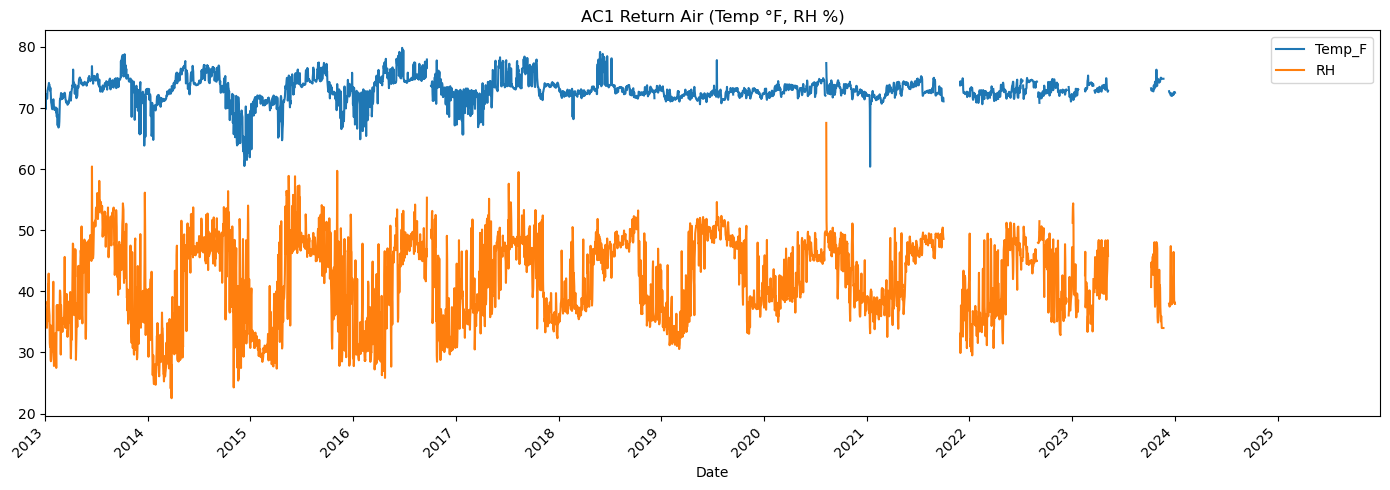

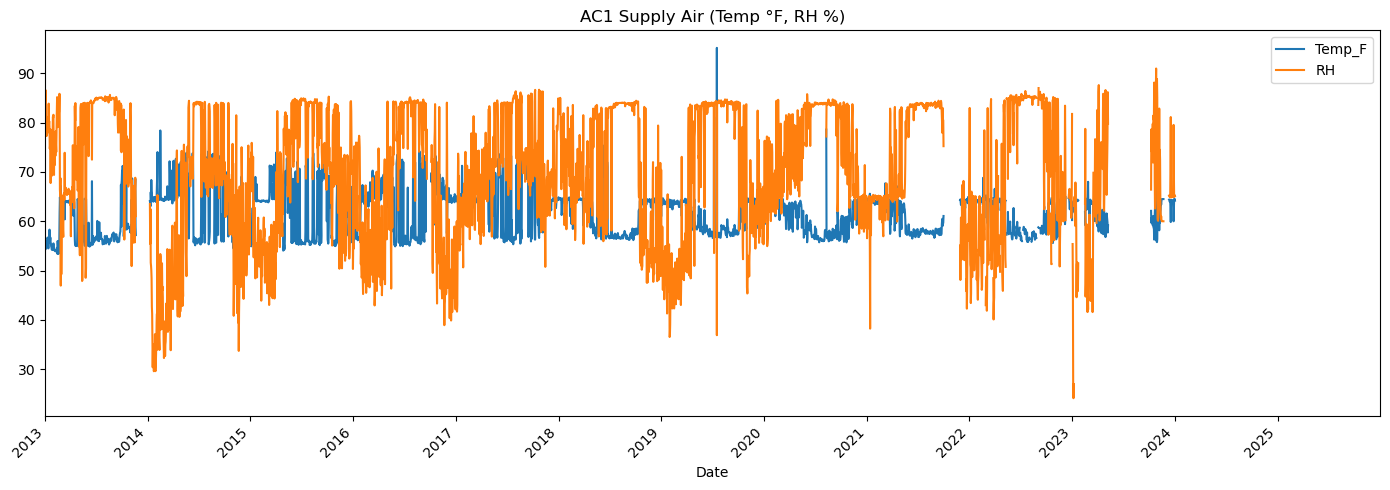

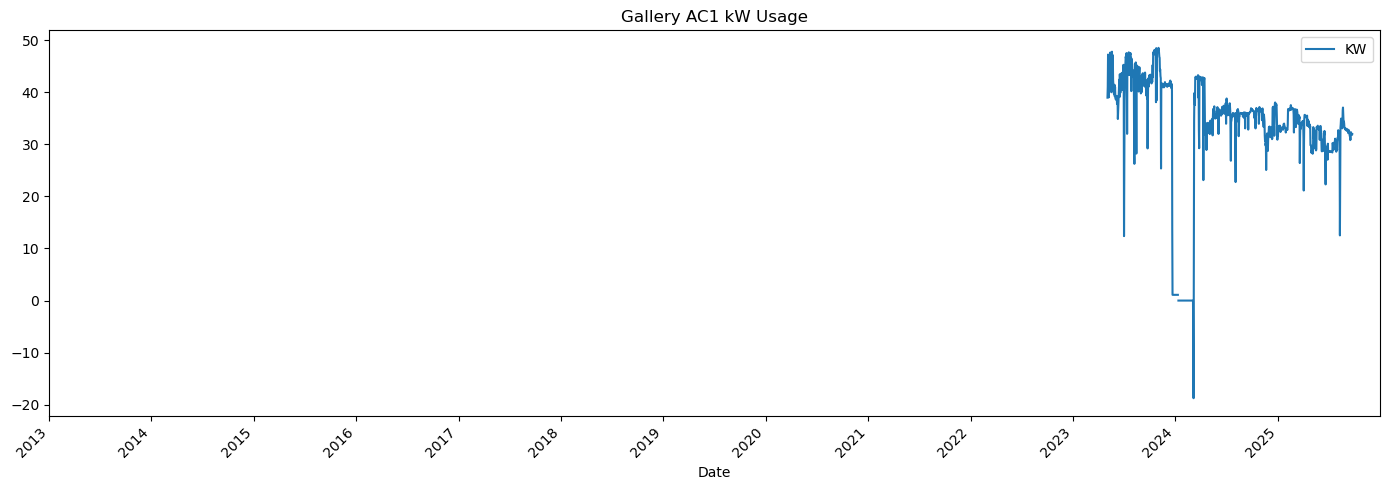

In [9]:
#supply and return air and enery from 2013 to 2024

%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def _read_text_lines(filepath, encoding="utf-8-sig"):
    try:
        with open(filepath, "r", encoding=encoding) as f:
            return f.readlines()
    except UnicodeDecodeError:
        with open(filepath, "r", encoding="latin-1") as f:
            return f.readlines()

def _strip_tz_suffix(ts: pd.Series) -> pd.Series:
    return ts.str.replace(r"\s[A-Z]{2,4}$", "", regex=True)

def load_pm2(filepath: str) -> pd.DataFrame:
    lines = _read_text_lines(filepath)
    header_idx = None
    for i, line in enumerate(lines):
        if line.startswith("YYYY-MM-DD"):
            header_idx = i
            break
    if header_idx is None:
        raise ValueError(f"Could not find 'YYYY-MM-DD' header in: {filepath}")

    df = pd.read_csv(
        filepath,
        sep="\t",
        skiprows=header_idx + 1,
        names=["DateTime", "Temp_F", "RH"],
        engine="python",
        encoding="latin-1"
    )
    df["DateTime"] = pd.to_datetime(df["DateTime"], errors="coerce")
    df["Temp_F"]   = pd.to_numeric(df["Temp_F"], errors="coerce")
    df["RH"]       = pd.to_numeric(df["RH"], errors="coerce")
    return df.dropna(subset=["DateTime"]).reset_index(drop=True)

def load_kw_csv(filepath: str) -> pd.DataFrame:
    lines = _read_text_lines(filepath, encoding="utf-8-sig")
    header_line = None
    for i, line in enumerate(lines):
        if line.strip().startswith("Timestamp,"):
            header_line = i
            break
    if header_line is None:
        raise ValueError("Could not locate 'Timestamp,...' header in KW CSV.")

    # Skip everything *before* the header row
    df = pd.read_csv(filepath, skiprows=header_line)

    ts_clean = _strip_tz_suffix(df["Timestamp"].astype(str).str.strip())
    df["DateTime"] = pd.to_datetime(ts_clean, format="%d-%b-%y %I:%M:%S %p", errors="coerce")
    df["KW"] = pd.to_numeric(df["Value"], errors="coerce")

    return df.dropna(subset=["DateTime"])[["DateTime", "KW"]]


def plot_series(df: pd.DataFrame, x: str, y_cols: list, title: str, start="2013-01-01", end="2025-12-31"):
    plt.figure(figsize=(14, 5))
    ax = plt.gca()

    daily = (df.set_index(x)[y_cols].resample("D").mean())
    idx = pd.date_range(start, end, freq="D")
    daily = daily.reindex(idx)        # NaN where missing
    daily.index.name = x

    for col in y_cols:
        ax.plot(daily.index, daily[col], label=col)

    ax.set_xlim(pd.to_datetime(start), pd.to_datetime(end))

    
    ax.xaxis.set_major_locator(mdates.YearLocator())          
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  
    # Alternative: every 3 months
    # ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    # ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    plt.title(title)
    plt.xlabel("Date")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ---------- Run ----------
PM2_RETURN_PATH = "/Users/asritha/Downloads/artresortation/eclimate data/(OBIX) AC1ReturnAir.pm2"
PM2_SUPPLY_PATH = "/Users/asritha/Downloads/artresortation/eclimate data/(OBIX) AC1SupplyAir.pm2"
KW_CSV_PATH     = "/Users/asritha/Downloads/artresortation/tridium energy data/Gallery-AC1-KW.csv"

ret = load_pm2(PM2_RETURN_PATH).sort_values("DateTime")
sup = load_pm2(PM2_SUPPLY_PATH).sort_values("DateTime")
kw  = load_kw_csv(KW_CSV_PATH).sort_values("DateTime")

plot_series(ret, "DateTime", ["Temp_F", "RH"], "AC1 Return Air (Temp °F, RH %)")
plot_series(sup, "DateTime", ["Temp_F", "RH"], "AC1 Supply Air (Temp °F, RH %)")
plot_series(kw,  "DateTime", ["KW"],          "Gallery AC1 kW Usage")


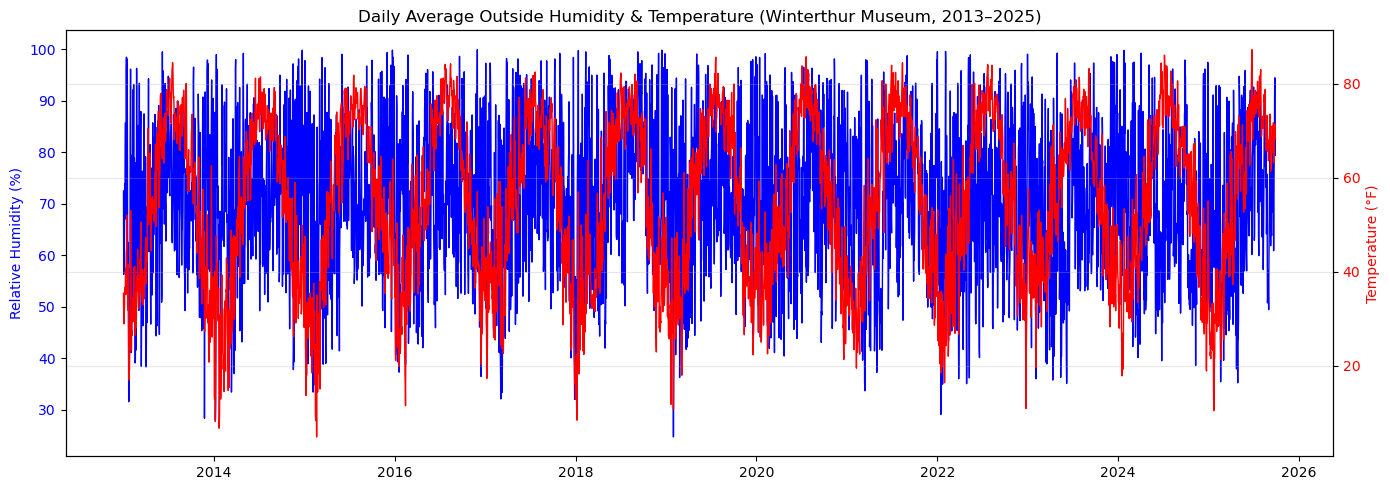

In [10]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

# Winterthur Museum coordinates
lat, lon = 39.8039, -75.6104

# Define time window
start_date = "2013-01-01"
end_date   = "2025-09-27"

# Fetch data from Open-Meteo: humidity + temperature (°C)
url = (
    "https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={lat}&longitude={lon}"
    f"&start_date={start_date}&end_date={end_date}"
    "&hourly=relative_humidity_2m,temperature_2m"
    "&timezone=America/New_York"
)
resp = requests.get(url).json()

# Convert to DataFrame
df = pd.DataFrame({
    "time": pd.to_datetime(resp["hourly"]["time"]),
    "humidity": resp["hourly"]["relative_humidity_2m"],
    "temperature_C": resp["hourly"]["temperature_2m"]
})

# Convert °C to °F
df["temperature_F"] = df["temperature_C"] * 9/5 + 32

# Compute daily averages
df_daily = df.resample("D", on="time").mean()

# Plot humidity and temperature with twin y-axes
fig, ax1 = plt.subplots(figsize=(14, 5))

ax1.plot(df_daily.index, df_daily["humidity"], color="blue", linewidth=1, label="Relative Humidity (%)")
ax1.set_ylabel("Relative Humidity (%)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(df_daily.index, df_daily["temperature_F"], color="red", linewidth=1, label="Temperature (°F)")
ax2.set_ylabel("Temperature (°F)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Daily Average Outside Humidity & Temperature (Winterthur Museum, 2013–2025)")
fig.tight_layout()
plt.grid(alpha=0.3)
plt.show()


In [14]:
pip install jupyterlab-git


Note: you may need to restart the kernel to use updated packages.


In [16]:
!git branch -M main

In [17]:
!git push -u origin main

fatal: 'origin' does not appear to be a git repository
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
